# Nested versus non-nested cross-validation

**Learning Outcomes**
1. Ability to understand the difference between nested cv and cv without nesting
2. Ability to understand how the data is leaked when cv without nesting is used
3. Ability to understand how cv without nesting overestimates the model performance
4. Ability to perform cv with and without nesting in sklearn

Disclaimer: this exercise has been adopted from sklearn [Nested versus non-nested cross-validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html) 

This example compares non-nested and nested cross-validation strategies on a
classifier of the iris dataset. Nested cross-validation (CV) is often used to
train a model in which hyper parameters also need to be optimized. Nested CV
estimates the generalization error of the underlying model and its
‎(hyper)parameter search. Choosing the parameters that maximize non-nested CV
biases the model to the dataset, yielding an overly-optimistic score.

Model selection without nested CV uses the same data to tune model parameters
and evaluate model performance. Information may thus "leak" into the model
and overfit the data. The magnitude of this effect is primarily dependent on
the size of the dataset and the stability of the model.

To avoid this problem, nested CV effectively uses a series of
train/validation/test set splits. In the inner loop (here executed by
:class:`GridSearchCV <sklearn.model_selection.GridSearchCV>`), the score is
approximately maximized by fitting a model to each training set, and then
directly maximized in selecting (hyper)parameters over the validation set. In
the outer loop (here in :func:`cross_val_score
<sklearn.model_selection.cross_val_score>`), generalization error is estimated
by averaging test set scores over several dataset splits.

The example below uses a support vector classifier with a non-linear kernel to
build a model with optimized hyper parameters by grid search. We compare the
performance of non-nested and nested CV strategies by taking the difference
between their scores.


In [1]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML('<style>.container {width: 85% !important}</style>'))

Automatically created module for IPython interactive environment
Average difference of 0.007581 with std. dev. of 0.007833.


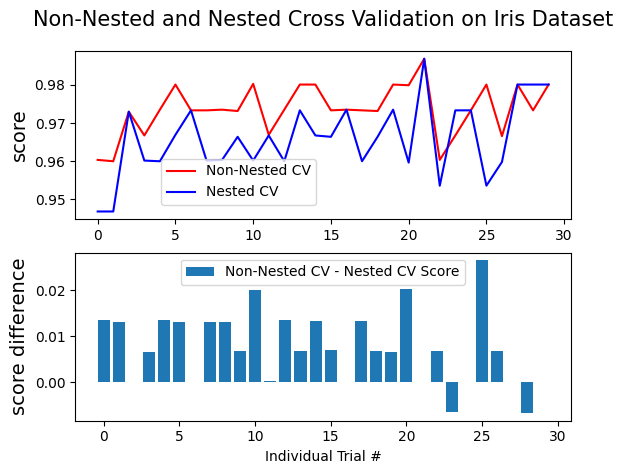

In [2]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

print(__doc__)

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    # the cross_val_score() function will execute the outer cross-validation procedure. 
    # This is performed on the configured GridSearchCV directly by automatically 
    # using the refit best performing model on the test set from the outer loop.
    
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()

#### **Interpreting the Results**:

1. **Score Difference**:
   - The `score_difference.mean()` indicates the average overestimation of the model's performance in non-nested CV compared to nested CV.
   - The `score_difference.std()` shows the variability in the score differences across trials.

2. **Expected Outcome**:
   - The non-nested scores are typically higher than the nested scores because non-nested CV evaluates the model using data already seen during hyperparameter optimization, leading to over-optimistic results.
   - Nested CV provides a more realistic performance estimate because the evaluation is conducted on completely unseen data.

3. **Plots**:
   - The first plot compares the scores from non-nested (red line) and nested CV (blue line) for all trials. The red line is often above the blue line, confirming the overestimation in non-nested CV.
   - The second plot shows the score difference for each trial, highlighting the magnitude of overestimation.

---

#### **Key Takeaways**:

1. **Non-Nested CV Overestimates Performance.** The model's performance appears artificially inflated due to data leakage during hyperparameter tuning.

2. **Nested CV is More Reliable.**  It provides an unbiased estimate of the model's true generalization performance on unseen data.

3. **Variability Across Trials.** Repeating the process (`NUM_TRIALS`) reduces the impact of randomness, making the comparison more robust.

This experiment emphasizes the importance of using nested cross-validation for rigorous model evaluation, especially when hyperparameter tuning is involved.